In [4]:
from s2flow.data import datasets
import os

os.chdir('/home/dhester/s2flow')

In [58]:
config = {
    'data': {
        "samples_par_path": "./data/cpb_lc/samples.par",
        "data_dir_path": "./data/cpb_lc",
        "augmentations": "spatial",
        "num_workers": 4,
        "pin_memory": True,
        "source_data": "s2sr",
        "fold": 0,
    }
}
train_dataloader, val_dataloader = datasets.get_lc_dataloaders(config)

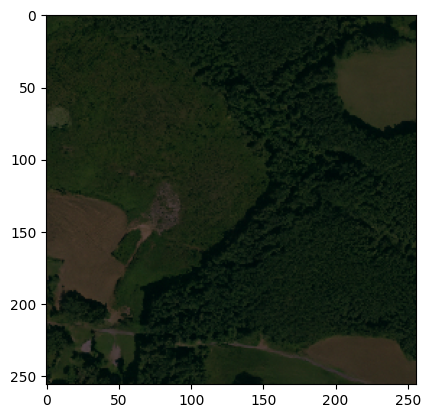

In [59]:
sample = next(iter(train_dataloader))



import matplotlib.pyplot as plt
plt.imshow(sample[0][0, :3, :, :].permute(1, 2, 0) * 3)  # Show band 4
# sample[0]

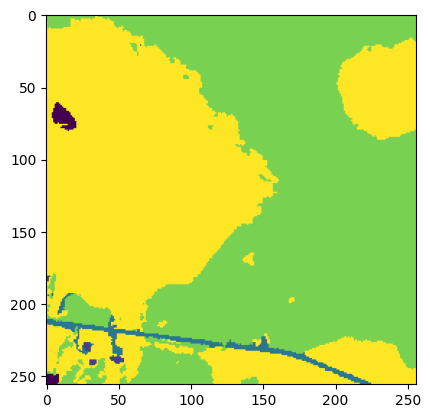

In [60]:
plt.imshow(sample[1][0, :, :])

In [62]:
import geopandas as gpd
samples_gdf = gpd.read_parquet("./data/cpb_lc/samples_fullscheme.par")
samples_gdf['s2sr_path'] = samples_gdf['s2_path'].str.replace('sentinel2', 'sentinel2_sr')

In [64]:
samples_gdf.to_parquet("./data/cpb_lc/samples_fullscheme.par")

In [71]:
import rasterio as rio

with rio.open('data/cpb_lc/landcover_fullscheme/00000.tif') as src:
    data = src.read()

In [76]:
data

array([[[22, 37, 37, ...,  6,  6,  6],
        [37, 37, 37, ...,  6,  6,  6],
        [43, 43, 37, ...,  6,  6,  6],
        ...,
        [ 6,  6,  6, ...,  6,  6,  6],
        [ 6,  6,  6, ...,  6,  6,  6],
        [ 6,  6,  6, ...,  6,  6,  6]]], shape=(1, 256, 256), dtype=uint8)